In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel("Cancer patient data.xlsx")

#### Note1: Use 8/25/16 as the end date of the analysis.

In [3]:
end_date = pd.to_datetime('2016-08-25')

#### Note4: Remove all patients who do not have a diagnosis date.

In [4]:
diagnosis_date = ["LUNG DT","PANCREAS_DT","THYROID_DT","COLORECTAL_DT","MELANOMA_DT"]
df = df.dropna(how = "all",subset = diagnosis_date).reset_index(drop=True)

#### Note2. Remove all patients who were diagnosed after 8/25/16.

In [5]:
df = df.drop(np.where(df[diagnosis_date] > end_date)[0]).reset_index(drop=True)

#### Note3. Keep patients who died after 8/25/16 (you need to censor this data).

In [6]:
# belonging to right censored
# df_die_after_enddate = df.iloc[np.where(df["DEATH_DATE_off"]>end_date)] and NAN

#### Note5.Categorize race into White, African-American, Asian/Mideast-Indian, and Others.

In [7]:
to_replace_values = ['White', 'Black/African-American', 'Unknown', 'Asian/Mideast Indian',
        'More than one Race', 'Patient Declined','Native Hawaiian/Other Pacific Islander',
        'American Indian or Alaska Native']

replace_values = ['White','African-American','Others','Asian/Mideast-Indian',
                  'Others','Others','Others','Others']

df = df.replace(to_replace = to_replace_values, value = replace_values)
df["race"].value_counts()

White                   2815
African-American         956
Others                   258
Asian/Mideast-Indian     117
Name: race, dtype: int64

In [8]:
# break into each cancer 
use_cols = ["sex","race","DEATH_DATE_off","BIRTH_DATE_off"]
df_LUNG = df[df["LUNG"] == 1][use_cols+["LUNG DT"]]
df_PANCREAS = df[df["PANCREAS"] == 1][use_cols+["PANCREAS_DT"]]
df_THYROID = df[df["THYROID"] == 1][use_cols+["THYROID_DT"]]
df_COLORECTAL = df[df["COLORECTAL"] == 1][use_cols+["COLORECTAL_DT"]]
df_MELANOMA = df[df["MELANOMA"] == 1][use_cols+["MELANOMA_DT"]]

In [9]:
df_list = [df_LUNG,df_PANCREAS,df_THYROID,df_COLORECTAL,df_MELANOMA]
diag_list = ['LUNG DT','PANCREAS_DT','THYROID_DT','COLORECTAL_DT','MELANOMA_DT']

In [10]:
for i,j in zip(df_list,diag_list):
    # Calculate the age of each patient at the time of cancer diagnosis.
    i["AGE"] = (i[j] - i["BIRTH_DATE_off"]).astype('timedelta64[Y]')
    
    # category age group in deciles (11-20, 21-30, ....) 
    age_decile = pd.interval_range(0,110,11)
    for m in range(len(i)):
        for n in range(len(age_decile)):
            if i.iloc[m,5] in age_decile[n]:
                i.iloc[m,5] = age_decile[n]
                break
    # if die earlier than analysis end date, duration is analysis end date - death date
    # otherwise duration is analysis end date - diagonis date, belonging to right censored
    i['duration_days'] = np.where((i['DEATH_DATE_off'] <= end_date),
                                       (i['DEATH_DATE_off'] - i[j]).dt.days,
                                       (end_date - i[j]).dt.days)
    
    # get whether each patient is still alive
    i['dead'] = np.where(i['DEATH_DATE_off'] <= end_date, 1, 0) 

In [11]:
# a cleaned data example 
df_PANCREAS

,sex,race,DEATH_DATE_off,BIRTH_DATE_off,PANCREAS_DT,AGE,duration_days,dead
24,Female,African-American,2012-11-22,1955-03-10,2012-10-12,"(50, 60]",41.0,1
30,Female,African-American,NaT,1929-06-27,2016-01-27,"(80, 90]",211.0,0
32,Male,White,NaT,1938-06-24,2013-11-19,"(70, 80]",1010.0,0
42,Male,African-American,2016-11-21,1952-08-30,2014-10-27,"(60, 70]",668.0,0
52,Male,African-American,2016-04-22,1956-07-15,2016-03-13,"(50, 60]",40.0,1
...,...,...,...,...,...,...,...,...
4127,Male,White,NaT,1946-03-15,2015-06-28,"(60, 70]",424.0,0
4129,Male,White,NaT,1946-07-17,2016-07-20,"(60, 70]",36.0,0
4130,Female,African-American,NaT,1948-10-02,2015-05-10,"(60, 70]",473.0,0
4131,Female,White,NaT,1947-03-14,2015-04-25,"(60, 70]",488.0,0


#### Plot kmf by sex

In [12]:
from lifelines import KaplanMeierFitter
def plot_kmf_by_sex(df):
    kmf = KaplanMeierFitter() 

    T = df['duration_days']     ## time to event
    E = df['dead']      ## event occurred or censored

    groups = df['sex']             
    ix1 = (groups == 'Male')   ## Cohort 1
    ix2 = (groups == 'Female')         ## Cohort 2

    kmf.fit(T[ix1], E[ix1], label='Male')    ## fit the cohort 1 data
    ax1 = kmf.plot(ci_show=False)

    kmf.fit(T[ix2], E[ix2], label='Female')         ## fit the cohort 2 data
    ax2 = kmf.plot(ax=ax1,ci_show=False)

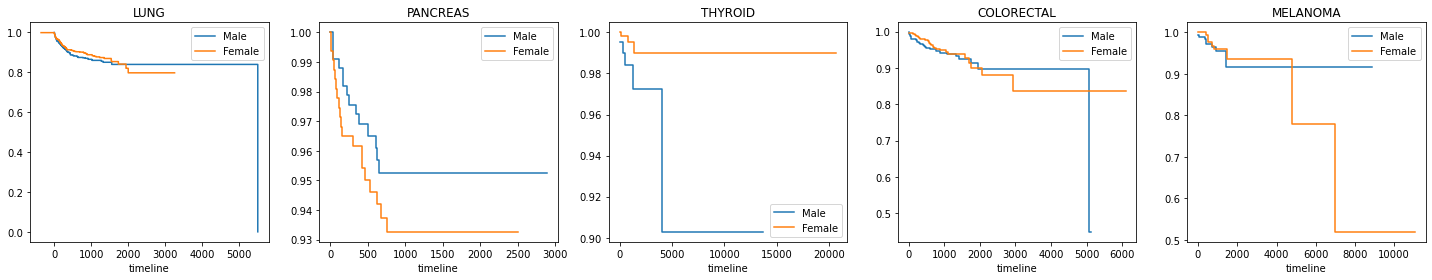

In [13]:
plt.figure(figsize=(20, 4))
plt.subplot(1,5,1)
plot_kmf_by_sex(df_LUNG)
plt.title("LUNG")

plt.subplot(1,5,2)
plot_kmf_by_sex(df_PANCREAS)
plt.title("PANCREAS")

plt.subplot(1,5,3)
plot_kmf_by_sex(df_THYROID)
plt.title("THYROID")

plt.subplot(1,5,4)
plot_kmf_by_sex(df_COLORECTAL)
plt.title("COLORECTAL")

plt.subplot(1,5,5)
plot_kmf_by_sex(df_MELANOMA)
plt.title("MELANOMA")

plt.tight_layout()
plt.show()

#### Plot kmf by race

In [14]:
def plot_kmf_by_race(df):
    kmf = KaplanMeierFitter() 

    T = df['duration_days']     ## time to event
    E = df['dead']      ## event occurred or censored

    groups = df['race']             
    ix1 = (groups == 'White')   ## Cohort 1
    ix2 = (groups == 'African-American')         ## Cohort 2
    ix3 = (groups == 'Asian/Mideast-Indian')         ## Cohort 3
    ix4 = (groups == 'Others')         ## Cohort 4

    kmf.fit(T[ix1], E[ix1], label='White')    
    ax1 = kmf.plot(ci_show=False)

    kmf.fit(T[ix2], E[ix2], label='African-American')        
    ax2 = kmf.plot(ax=ax1,ci_show=False)

    kmf.fit(T[ix3], E[ix3], label='Asian/Mideast-Indian')         
    ax3 = kmf.plot(ax=ax2,ci_show=False)

    kmf.fit(T[ix4], E[ix4], label='Others')     
    ax4 = kmf.plot(ax=ax3,ci_show=False)

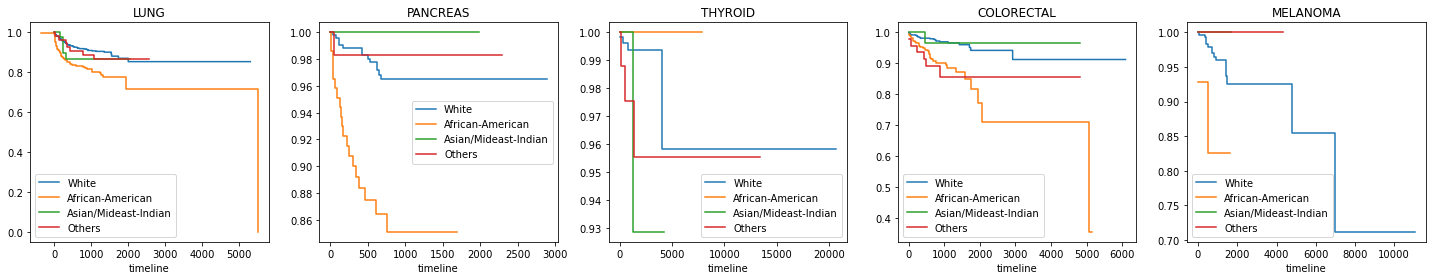

In [15]:
plt.figure(figsize=(20, 4))
plt.subplot(1,5,1)
plot_kmf_by_race(df_LUNG)
plt.title("LUNG")

plt.subplot(1,5,2)
plot_kmf_by_race(df_PANCREAS)
plt.title("PANCREAS")

plt.subplot(1,5,3)
plot_kmf_by_race(df_THYROID)
plt.title("THYROID")

plt.subplot(1,5,4)
plot_kmf_by_race(df_COLORECTAL)
plt.title("COLORECTAL")

plt.subplot(1,5,5)
plot_kmf_by_race(df_MELANOMA)
plt.title("MELANOMA")

plt.tight_layout()
plt.show()

#### Plot kmf by age group(decile)

In [16]:
def plot_kmf_by_age_group_LUNG(df):
    kmf = KaplanMeierFitter() 

    T = df['duration_days']     ## time to event
    E = df['dead']      ## event occurred or censored
    
    df["AGE"] = df["AGE"].astype(str)
    groups = df['AGE'] 
    ix = (groups == '(0, 10]')
   
    kmf.fit(T[ix], E[ix], label='(0, 10]') 
    
    ax = kmf.plot(ci_show=False)
    for i in age_decile[1:]:
        ix = (groups == str(i))
        kmf.fit(T[ix], E[ix], label=str(i))    
        ax = kmf.plot(ax = ax, ci_show=False)

       
def plot_kmf_by_age_group_PANCREAS(df):
    kmf = KaplanMeierFitter() 

    T = df['duration_days']     ## time to event
    E = df['dead']      ## event occurred or censored
    
    df["AGE"] = df["AGE"].astype(str)
    groups = df['AGE'] 
    ix = (groups == '(20, 30]')
   
    kmf.fit(T[ix], E[ix], label='(20, 30]') 
    
    ax = kmf.plot(ci_show=False)
    for i in age_decile[3:10]:
        ix = (groups == str(i))
        kmf.fit(T[ix], E[ix], label=str(i))    
        ax = kmf.plot(ax = ax, ci_show=False)
        
def plot_kmf_by_age_group_THYROID(df):
    kmf = KaplanMeierFitter() 

    T = df['duration_days']     ## time to event
    E = df['dead']      ## event occurred or censored
    
    df["AGE"] = df["AGE"].astype(str)
    groups = df['AGE'] 
    ix = (groups == '(10, 20]')
   
    kmf.fit(T[ix], E[ix], label='(10, 20]') 
    
    ax = kmf.plot(ci_show=False)
    for i in age_decile[1:9]:
        ix = (groups == str(i))
        kmf.fit(T[ix], E[ix], label=str(i))    
        ax = kmf.plot(ax = ax, ci_show=False)   

        

def plot_kmf_by_age_group_COLORECTAL_MELANOMA(df):
    kmf = KaplanMeierFitter() 

    T = df['duration_days']     ## time to event
    E = df['dead']      ## event occurred or censored
    
    df["AGE"] = df["AGE"].astype(str)
    groups = df['AGE'] 
    ix = (groups == '(10, 20]')
   
    kmf.fit(T[ix], E[ix], label='(10, 20]') 
    
    ax = kmf.plot(ci_show=False)
    for i in age_decile[2:10]:
        ix = (groups == str(i))
        kmf.fit(T[ix], E[ix], label=str(i))    
        ax = kmf.plot(ax = ax, ci_show=False)
  

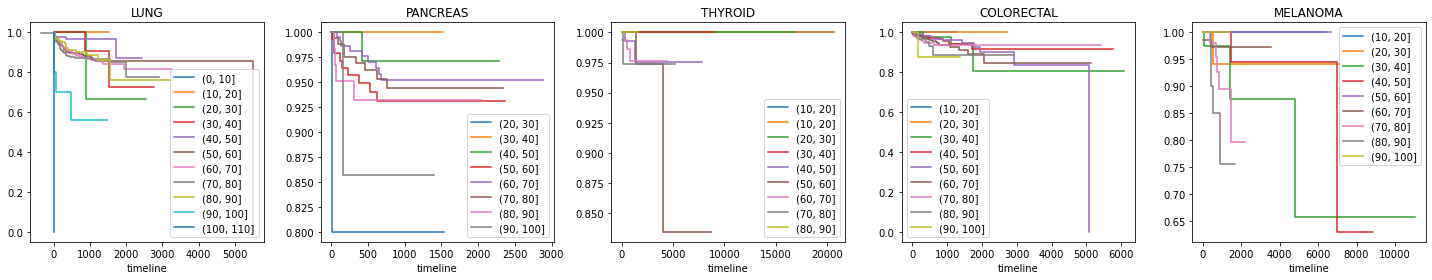

In [17]:
plt.figure(figsize=(20, 4))
plt.subplot(1,5,1)
plot_kmf_by_age_group_LUNG(df_LUNG)
plt.title("LUNG")

plt.subplot(1,5,2)
plot_kmf_by_age_group_PANCREAS(df_PANCREAS)
plt.title("PANCREAS")

plt.subplot(1,5,3)
plot_kmf_by_age_group_THYROID(df_THYROID)
plt.title("THYROID")

plt.subplot(1,5,4)
plot_kmf_by_age_group_COLORECTAL_MELANOMA(df_COLORECTAL)
plt.title("COLORECTAL")

plt.subplot(1,5,5)
plot_kmf_by_age_group_COLORECTAL_MELANOMA(df_MELANOMA)
plt.title("MELANOMA")

plt.tight_layout()
plt.show()

#### 1.which cancer has the highest survival for this cohort?



In [18]:
dt_name = ["LUNG","PANCREAS","THYROID","COLORECTAL","MELANOMA"]
for data,name in zip(df_list,dt_name):
    kmf = KaplanMeierFitter() 
    T = data['duration_days']    
    E = data['dead']     
    kmf.fit(T, E)
    print("Mean survival rate of "+str(name)+":",np.round(np.mean(kmf.survival_function_.values),3))

Mean survival rate of LUNG: 0.882
Mean survival rate of PANCREAS: 0.951
Mean survival rate of THYROID: 0.989
Mean survival rate of COLORECTAL: 0.939
Mean survival rate of MELANOMA: 0.951


THYROID has the highest survival rate, which mean survival rate reached 0.989

#### 2.which cancer has the lowest survival for this cohort?

LUNG has the lowest survival rate, which mean survival rate was 0.882

#### 3.how many patients had 2 cancer diagnosis?

In [19]:
len(df[df[dt_name].sum(axis=1)>1])

29

#### 4.which age group has the lowest survival after 400 days since cancer diagnosis?

In [20]:
all_cancer = pd.concat([df_LUNG,df_PANCREAS,df_THYROID,df_COLORECTAL,df_MELANOMA])
all_cancer["AGE"] = all_cancer["AGE"].astype(str)
groups = all_cancer['AGE'] 
kmf = KaplanMeierFitter() 
T = all_cancer['duration_days']    
E = all_cancer['dead']     
for i in age_decile:
    ix = (groups == str(i))
    kmf.fit(T[ix], E[ix], label=str(i))
    print("Survival rate of age Group:"+str(i)+" after 400 days:",np.round(kmf.predict(400),4))

Survival rate of age Group:(0, 10] after 400 days: 1.0
Survival rate of age Group:(10, 20] after 400 days: 1.0
Survival rate of age Group:(20, 30] after 400 days: 0.9914
Survival rate of age Group:(30, 40] after 400 days: 0.9915
Survival rate of age Group:(40, 50] after 400 days: 0.9849
Survival rate of age Group:(50, 60] after 400 days: 0.9549
Survival rate of age Group:(60, 70] after 400 days: 0.9513
Survival rate of age Group:(70, 80] after 400 days: 0.9241
Survival rate of age Group:(80, 90] after 400 days: 0.9359
Survival rate of age Group:(90, 100] after 400 days: 0.8199
Survival rate of age Group:(100, 110] after 400 days: 0.0


After 400 days, age group of (100-110] has the lowest survival rate which is 0, but it's out of a small sample size, so except this, age group of (90-100] will be the lowest survival rate which is is 0.8199.

#### 5.what is the survival rate for females with colorectal cancer after 1000 days since diagnosis?

In [21]:
def pred_survival_rate(df,group,value,days):
    kmf = KaplanMeierFitter() 

    T = df['duration_days']     ## time to event
    E = df['dead']      ## event occurred or censored
           
    ix1 = (df[group] == value) 

    kmf.fit(T[ix1], E[ix1], label=value)  
    print(np.round(kmf.predict(days),4))

In [22]:
pred_survival_rate(df_COLORECTAL,'sex','Female',1000)

0.9484


#### 6.what is the survival rate for females with colorectal cancer after 1000 days since diagnosis?

In [23]:
pred_survival_rate(df_LUNG,'sex','Male',300)

0.915


#### 7.what is the survival rate for females with melanoma cancer after 1200 days since diagnosis?

In [24]:
pred_survival_rate(df_MELANOMA,'sex','Female',1200)

0.9588


#### 8.what is the survival rate for males with thyroid cancer after 1500 days since diagnosis?

In [25]:
pred_survival_rate(df_THYROID,'sex','Male',1500)

0.9723


#### 9.what is the survival rate for males with pancreatic cancer after 2200 days since diagnosis?

In [26]:
pred_survival_rate(df_PANCREAS,'sex','Male',2200)

0.9527


#### 10.what is the survival rate for African-Americans with colorectal cancer after 2000 days since diagnosis?

In [27]:
pred_survival_rate(df_COLORECTAL,'race','African-American',2000)

0.7706


#### 11.what is the survival rate for Whites with lung cancer after 1000 days since diagnosis?

In [28]:
pred_survival_rate(df_LUNG,'race','White',1000)

0.9093


#### 12.what is the survival rate for African-Americans with melanoma cancer after 2 years since diagnosis?

In [29]:
pred_survival_rate(df_MELANOMA,'race','African-American',365*2)

0.8254


#### 13.what is the survival rate for Whites with pancreatic cancer after 3 years since diagnosis?

In [30]:
pred_survival_rate(df_PANCREAS,'race','White',365*3)

0.9653


#### 14.what is the survival rate for Asians with thyroid cancer after 1500 days since diagnosis?

In [31]:
pred_survival_rate(df_THYROID,'race','Asian/Mideast-Indian',1500)

0.9286


#### 15.which age group has the lowest survival for colorectal cancer at the end of the study?

In [32]:
groups = df_COLORECTAL['AGE'] 
kmf = KaplanMeierFitter() 
T = df_COLORECTAL['duration_days']    
E = df_COLORECTAL['dead']     
for i in age_decile[1:10]:
    ix = (groups == str(i))
    kmf.fit(T[ix], E[ix], label=str(i))
    print("Survival rate of age Group:"+str(i)+" at the end of analysis:",
          np.round(np.mean(kmf.predict((end_date - df_COLORECTAL["COLORECTAL_DT"]).dt.days)),4))

Survival rate of age Group:(10, 20] at the end of analysis: 1.0
Survival rate of age Group:(20, 30] at the end of analysis: 1.0
Survival rate of age Group:(30, 40] at the end of analysis: 0.9426
Survival rate of age Group:(40, 50] at the end of analysis: 0.953
Survival rate of age Group:(50, 60] at the end of analysis: 0.9473
Survival rate of age Group:(60, 70] at the end of analysis: 0.9279
Survival rate of age Group:(70, 80] at the end of analysis: 0.9415
Survival rate of age Group:(80, 90] at the end of analysis: 0.9034
Survival rate of age Group:(90, 100] at the end of analysis: 0.8779


Age group of (90-100) has the lowest survival at the end of analysis, which is 0.8779

#### 16.which age group has the highest survival for lung cancer at the end of the study?

In [33]:
groups = df_LUNG['AGE'] 
kmf = KaplanMeierFitter() 
T = df_LUNG['duration_days']    
E = df_LUNG['dead']     
for i in age_decile:
    ix = (groups == str(i))
    kmf.fit(T[ix], E[ix], label=str(i))
    print("Survival rate of age Group:"+str(i)+" at the end of analysis:",
          np.round(np.mean(kmf.predict((end_date - df_LUNG["LUNG DT"]).dt.days)),4))

Survival rate of age Group:(0, 10] at the end of analysis: 1.0
Survival rate of age Group:(10, 20] at the end of analysis: 1.0
Survival rate of age Group:(20, 30] at the end of analysis: 0.813
Survival rate of age Group:(30, 40] at the end of analysis: 0.9209
Survival rate of age Group:(40, 50] at the end of analysis: 0.9605
Survival rate of age Group:(50, 60] at the end of analysis: 0.8784
Survival rate of age Group:(60, 70] at the end of analysis: 0.8721
Survival rate of age Group:(70, 80] at the end of analysis: 0.868
Survival rate of age Group:(80, 90] at the end of analysis: 0.8777
Survival rate of age Group:(90, 100] at the end of analysis: 0.5834
Survival rate of age Group:(100, 110] at the end of analysis: 0.0


Age group of (10-20) and (20-30) has the highest survival at the end of analysis, which is 1, but it's out of small sample size, except this, age Group of (40, 50] has the highest survival rate which is 0.9605

#### 17.what is the survival rate for 61-70 age group with melanoma cancer after 5 years since diagnosis?

In [34]:
pred_survival_rate(df_MELANOMA,'AGE','(60, 70]',5*365)

0.9722


#### 18.what is the survival rate for 21 - 30 age group with pancreatic cancer after a year since diagnosis?

In [35]:
pred_survival_rate(df_PANCREAS,'AGE','(20, 30]',365)

0.8


#### 19. what is the survival rate for 51-60 age group with thyroid cancer after 2200 days since diagnosis?

In [36]:
pred_survival_rate(df_THYROID,'AGE','(50, 60]',2200)

0.9737


#### 20.which race has the high survival for all cancers after 2500 days since diagnosis?

In [37]:
groups_race = all_cancer['race'] 
kmf = KaplanMeierFitter() 
T = all_cancer['duration_days']    
E = all_cancer['dead']     
for i in all_cancer["race"].value_counts().index:
    ix = (groups_race == i)
    kmf.fit(T[ix], E[ix], label=i)
    print("Survival rate of "+i+" after 2500 days:",np.round(kmf.predict(2500),4))

Survival rate of White after 2500 days: 0.9263
Survival rate of African-American after 2500 days: 0.7428
Survival rate of Others after 2500 days: 0.9228
Survival rate of Asian/Mideast-Indian after 2500 days: 0.9235


Race of White group has highest survival rate of all cancers after 2500 days, which is 0.9263